## Analisando a dinâmica da serie temporal e o comportamento do preço ##

In [186]:
import quandl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [187]:
gg = pd.read_csv('google.csv', keep_default_na=False)

In [188]:
gg.tail(3)

,Date,Open,High,Low,Close,Adj Close,Volume
2765,2019-06-24,1119.609985,1122.000000,1111.010010,1115.520020,1115.520020,1395600
2766,2019-06-25,1112.660034,1114.349976,1083.800049,1086.349976,1086.349976,1546900
2767,2019-06-26,1086.500000,1092.969971,1072.239990,1079.800049,1079.800049,1799100


In [189]:
# Drop all colluns excpt Close price
    
dol = gg.drop(['Date','Open','High','Low', 'Adj Close','Volume', ],axis=1)


In [190]:
gg.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-06-27,262.135071,263.287567,255.880737,262.328796,262.328796,10965700
1,2008-06-30,264.514587,267.261719,259.839996,261.509125,261.509125,7579500
2,2008-07-01,258.111237,266.625854,256.829559,265.637299,265.637299,9984200
3,2008-07-02,266.521545,268.444031,261.330292,261.817139,261.817139,8500900
4,2008-07-03,263.724731,267.872742,262.045654,266.764954,266.764954,4832100


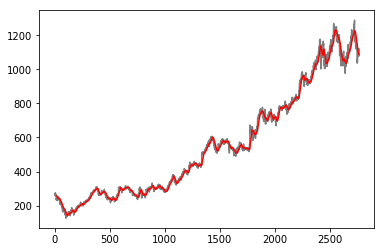

In [191]:
r = dol.rolling(window=21)
plt.plot(dol, 'k-', alpha = 0.5)
plt.plot(r.mean(), 'r-')

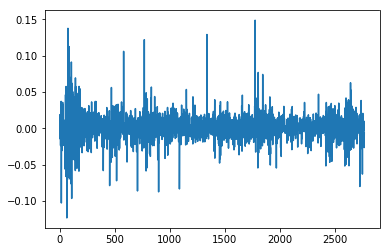

In [192]:
#logaritmo serie de retorno

dol_ret = np.log(dol).diff().dropna()
plt.plot(dol_ret)

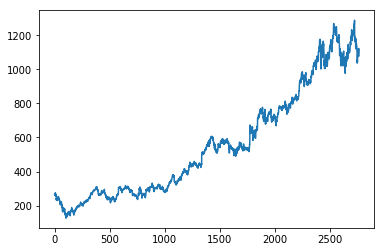

In [193]:
# recosntruindo a série de preço Pt a partir dos retornos Xt
# p_(t-1) exp (x_t)
doll= np.cumprod(np.r_[dol.values[0], np.exp(dol_ret.values.reshape(len(dol_ret)))])
plt.plot(doll)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff8dca5d5f8>]],
      dtype=object)

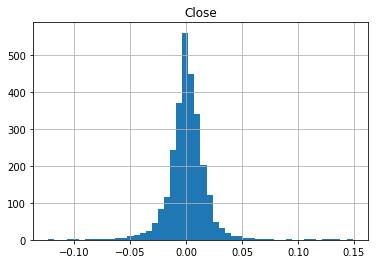

In [194]:
#ver comportamento da série de retorno
dol_ret.hist(bins=50)

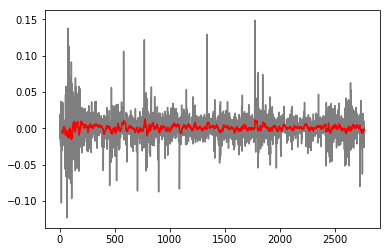

In [195]:
#média movel dos retornos
#oscilando bem menos
r = dol_ret.rolling(window=21)
plt.plot(dol_ret, 'k-', alpha = 0.5)
plt.plot(r.mean(), 'r-')

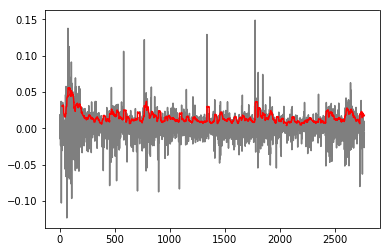

In [196]:
#desvio padrão
plt.plot(dol_ret, 'k-', alpha = 0.5)
plt.plot(r.std(), 'r-')

In [197]:
#Modelo de auto regressão = Xt = Y + TETA... VER NO VIDEO

In [198]:
#statsmodels é usada pra explicar fenomenos de forma estatistica
#TSA time series analisis
import statsmodels.tsa as tsa
import statsmodels.api as sm

In [199]:
#ARMA auto regressos 
#mle maximum likelyhood extimator
model = sm.tsa.ARMA(dol_ret.as_matrix(), (1, 0)).fit(trend = 'c')
print (model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 2767
Model:                     ARMA(1, 0)   Log Likelihood                7268.575
Method:                       css-mle   S.D. of innovations              0.017
Date:                Mon, 01 Jul 2019   AIC                         -14531.151
Time:                        22:47:33   BIC                         -14513.374
Sample:                             0   HQIC                        -14524.730
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.550      0.121      -0.000       0.001
ar.L1.y       -0.0083      0.019     -0.436      0.663      -0.046       0.029
                                    Roots           

/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [200]:
model.params

array([ 0.00051139, -0.00828868])

In [201]:
dol_ar_proc = tsa.arima_process.ArmaProcess(np.r_[1, -model.params], [1])

In [202]:
dol_ar_sim = dol_ar_proc.generate_sample(len(dol_ret))*model.resid.std()

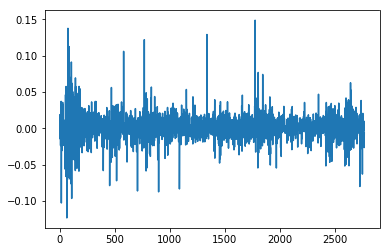

In [203]:
#real
plt.plot(dol_ret)

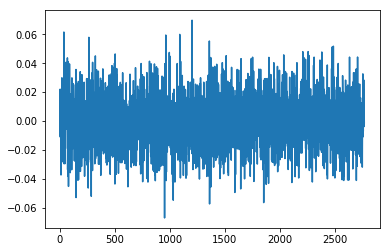

In [204]:
#simulado
plt.plot(dol_ar_sim)

In [205]:
doll = np.cumprod(np.r_[dol.values[1], np.exp(dol_ar_sim)])

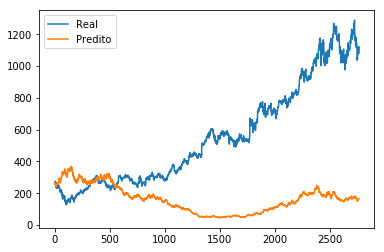

In [206]:
#real
plt.plot(dol, label='Real')
#simulado = predito
plt.plot(doll, label='Predito')
plt.legend(loc='upper left')
plt.show()

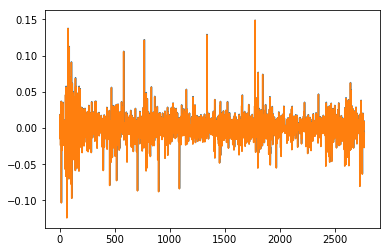

In [207]:
#residuos
#quase tudo virou residuo
plt.plot(dol_ret)
plt.plot(model.resid)
plt.show()

In [208]:
#testando GARCH
from arch import arch_model

In [209]:
am = arch_model(dol_ret*100, p=1, q=1)

In [210]:
res = am.fit(disp='off')

In [211]:
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -5220.51
Distribution:                  Normal   AIC:                           10449.0
Method:            Maximum Likelihood   BIC:                           10472.7
                                        No. Observations:                 2767
Date:                Mon, Jul 01 2019   Df Residuals:                     2763
Time:                        22:47:35   Df Model:                            4
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0607  2.997e-02      2.024  4.293e-02 [1.930e-0

In [212]:
# Mu é a média do retorno

In [213]:
# simulando garch
# entender o comportamento da variavel
# simulando o modelo matematico
def simulate_garch(params, nobs, var=0):
    e = np.random.randn(nobs)
    var = np.zeros(len(e)) + var
    x = np.zeros(len(e))
    
    for t in range(len(e)):
        var[t] = params[1] + params[2] * x[t-1]**2 + params[3] * var[t-1]
        x[t] = params[0] + e[t] * np.sqrt(var[t])
        
    return x

In [214]:
res.params

mu          0.060670
omega       0.155529
alpha[1]    0.096580
beta[1]     0.854568
Name: params, dtype: float64

In [215]:
dol_am_sim = simulate_garch(res.params, len(dol_ret))/100

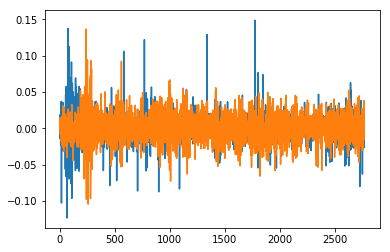

In [216]:
#retorno dolar
plt.plot(dol_ret)
#retorno dolar simulado = predito
plt.plot(dol_am_sim)
plt.show()

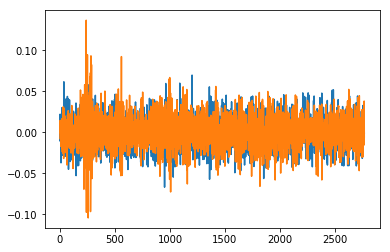

In [217]:
#retorno dolar
plt.plot(dol_ar_sim)
#retorno dolar simulado = predito
plt.plot(dol_am_sim)
plt.show() 

In [218]:
doll = np.cumprod(np.r_[dol.values[1], np.exp(dol_am_sim)])

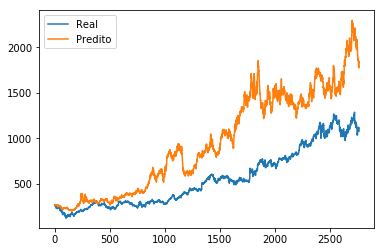

In [226]:
#real
plt.plot(dol, label='Real')
#simulado = predito
plt.plot(doll, label='Predito')
plt.legend(loc='upper left')
plt.show()

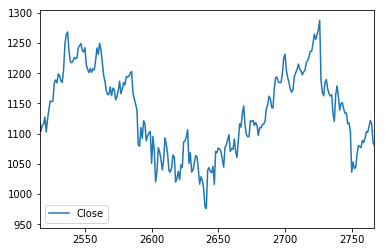

In [220]:
#predição
dol.tail(252).plot()
paths = np.zeros((100,21))
for i in range(100):
    dol_am_sim = simulate_garch(res.params, 20)/100
    path = np.cumprod(np.r_[dol.values[-1], np.exp(dol_am_sim)])
    paths[i,:] = path
    plt.plot(range(999, 999+21), path, '-g', alpha = 0.25)
plt.plot(range(999, 999+21), np.mean(paths, 0), '-r')

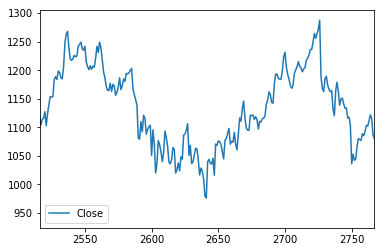

In [221]:
dol.tail(252).plot()
for i in range(100):
    dol_am_sim = simulate_garch(res.params, 20)/100
    path = np.cumprod(np.r_[dol.values[-1], np.exp(dol_am_sim)])
    paths[i,:] = path
    plt.plot(range(999, 999+21), path, '-g', alpha = 0.25)
plt.plot(range(999, 999+21), np.mean(paths, 0), '-r');

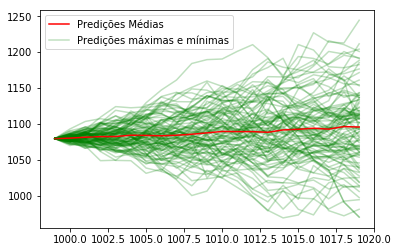

In [222]:
for i in range(100):
    dol_am_sim = simulate_garch(res.params, 20)/100
    path = np.cumprod(np.r_[dol.values[-1], np.exp(dol_am_sim)])
    paths[i,:] = path
    plt.plot(range(999, 999+21), path, '-g', alpha = 0.25)
plt.plot(range(999, 999+21), np.mean(paths, 0), '-r', label='Predições Médias')
plt.plot(range(999, 999+21), path, '-g', alpha = 0.25, label='Predições máximas e mínimas')
plt.legend(loc='upper left')

In [223]:
dol_am_sim

array([ 0.00401934,  0.00276125, -0.00863833, -0.00620535,  0.00621682,
        0.01180786,  0.0134104 ,  0.00446064,  0.01238029,  0.01361555,
       -0.00568981, -0.00087532, -0.02323197,  0.02808415, -0.02987902,
       -0.0200991 , -0.02960918, -0.01383344, -0.04392511, -0.02129224])

In [224]:
int = simulate_garch(res.params, 20)

In [225]:
int

array([-0.128516  , -0.72176008,  0.63261045,  0.69905302, -0.77078132,
        0.25143715,  0.36497197, -0.70631377, -1.37446026,  0.08004288,
       -0.08203328, -0.03943115,  0.4278073 ,  1.08304679,  1.12538632,
        1.22249907,  1.00438822, -1.99445924,  0.7130958 ,  0.31812343])